In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflect
infl = inflect.engine()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammiyauchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
ib = pd.read_csv('CSE576-NLP/img_aug/output/image_aug_analysis_cocoqa_val2014_ib_only.csv').dropna().reset_index(drop=True)
fla = pd.read_csv('CSE576-NLP/img_aug/output/image_aug_analysis_cocoqa_val2014_fla_only.csv').dropna().reset_index(drop=True)

ib.head()

,img_id,question,answer,type,ib_original,ib_blurSm,ib_blurMd,ib_blurLg,ib_chnlDrp,ib_solar,ib_elastic
0,418471,what sits in front of a cup of soda,pizza,0,pizza,pizza,pizza,pizza,pizza,pizza,coca cola
1,412019,what flies in front of a twin engine aircraft,bird,0,bird,bird,bird,bird,bird,bird,bird
2,568675,what is full of many types of donuts,box,0,box,box,box,box,box,box,box
3,430079,what does an eagle statue in front of painting...,room,0,clock,courthouse,courthouse,courthouse,clock,clock,clock
4,562595,what do two elephants lock together in the bru...,trucks,0,tusks,fight,fight,fight,fight,fight,fight


In [3]:
def accuracy_exact_match(pred, target):
    '''
    Checks if the target is a substring of the prediction. Makes pred and target strings lowercase first. 
    '''

    comp = []
    for t, p in zip(target, pred):
        t = t.lower()
        p = p.lower()
        if p in ['0','1','2','3','4','5','6','7','8','9']:
            p = infl.number_to_words(int(p))
        comp.append(t in p)
    # comp = np.array([t.lower() in p.lower() for t, p in zip(target, pred)])
    return comp


def accuracy_synonmy(pred, target):
    '''
    Checks if the target or is a substring of the prediction or a synanym of the prediction. Makes pred adn target strings lowercase first.
    '''
    comp = [any(syn.lower() in p.lower() for syn in get_synonyms(t.lower())) for p, t in zip(pred, target)]
    # comp = np.array([p.lower() in get_synonyms(t) for p, t in zip(pred, target)])
    return comp
    # return comp.sum() / len(comp)


def get_synonyms(word):
    synonyms = [word]
    for syn in wordnet.synsets(word.lower()):
        for lm in syn.lemmas():
            synonyms.append(lm.name().replace('_', ' '))
    # synonyms = ' '.join(synonyms)
    return synonyms

def accuracy_columns(df, columns):
    eval = pd.DataFrame()

    for c in columns:
        eval[f'{c}_exact_accuracy'] = accuracy_exact_match(df[c], df['answer'])
        eval[f'{c}_synonym_accuracy'] = accuracy_synonmy(df[c], df['answer'])
        eval[f'{c}_exact_accuracy'] = eval[f'{c}_exact_accuracy'].astype(int)
        eval[f'{c}_synonym_accuracy'] = eval[f'{c}_synonym_accuracy'].astype(int)

    return eval


In [4]:
ib_eval = accuracy_columns(ib, ib.columns[4:])
fla_eval = accuracy_columns(fla, fla.columns[4:])
ib_eval

,ib_original_exact_accuracy,ib_original_synonym_accuracy,ib_blurSm_exact_accuracy,ib_blurSm_synonym_accuracy,ib_blurMd_exact_accuracy,ib_blurMd_synonym_accuracy,ib_blurLg_exact_accuracy,ib_blurLg_synonym_accuracy,ib_chnlDrp_exact_accuracy,ib_chnlDrp_synonym_accuracy,ib_solar_exact_accuracy,ib_solar_synonym_accuracy,ib_elastic_exact_accuracy,ib_elastic_synonym_accuracy
0,1,1,1,1,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23322,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23323,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23324,1,1,1,1,1,1,1,1,1,1,0,0,1,1
23325,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [5]:
def get_results(df, eval, question_type=[0, 1, 2, 3]):
    results = eval.iloc[df[df['type'].isin(question_type)].index]
    results = (results.sum() / results.count()).reset_index()
    results[['model', 'aug', 'metric', '_']] = results['index'].str.split('_', expand=True)
    results = results.sort_values(by=['metric', 'model', 'aug'])
    results = results.rename(columns = {0: 'accuracy'})
    return results

def merge_results(question_type=[0, 1, 2, 3]):
    return pd.concat([
        get_results(ib, ib_eval, question_type), 
        get_results(fla, fla_eval, question_type)
    ])


#### Plots

In [7]:

def plot_blur_results(results, title):
    # print(len(results))
    # display(results)
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['blurLg', 'blurMd', 'blurSm', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()


def plot_elastic_transform_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['elastic', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

def plot_channel_drop_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['chnlDrp', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

def plot_solarization_results(results, title):
    g = sns.barplot(
        data = results[(results['metric'] == 'exact') & (results['aug'].isin(['solar', 'original']))],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

def plot_all(results, title):
    results = results.sort_values(by=['model', 'accuracy'], ascending=False)
    # results = pd.concat([       # move original to first column
    #     results[results['aug'] == 'original'].copy(),
    #     results[results['aug'] != 'original']
    # ])
    g = sns.barplot(
        data = results[results['metric'] == 'exact'],
        x = 'aug', y = 'accuracy', hue='model'
    )
    g.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    for container in g.containers:
        g.bar_label(container, fmt='%.4f')
    plt.show()

In [16]:
q_all = merge_results(question_type=[0,1,2,3])
q_exColor = merge_results(question_type=[0,1,3])
q_0 = merge_results(question_type=[0])
q_1 = merge_results(question_type=[1])
q_2 = merge_results(question_type=[2])
q_3 = merge_results(question_type=[3])

### Image Blur Results

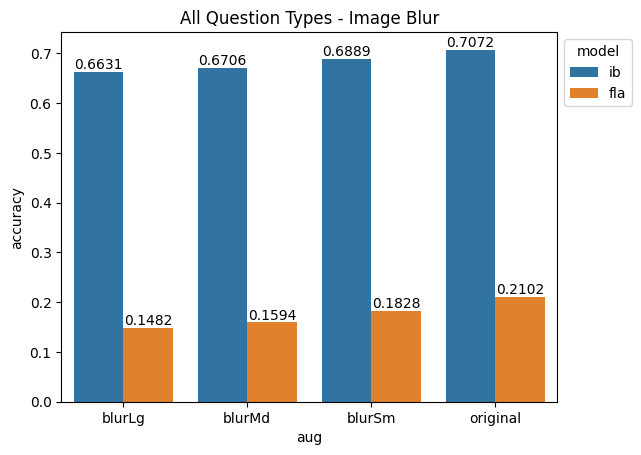

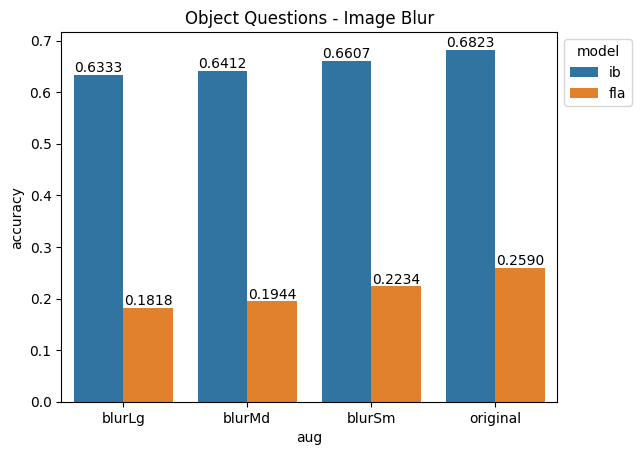

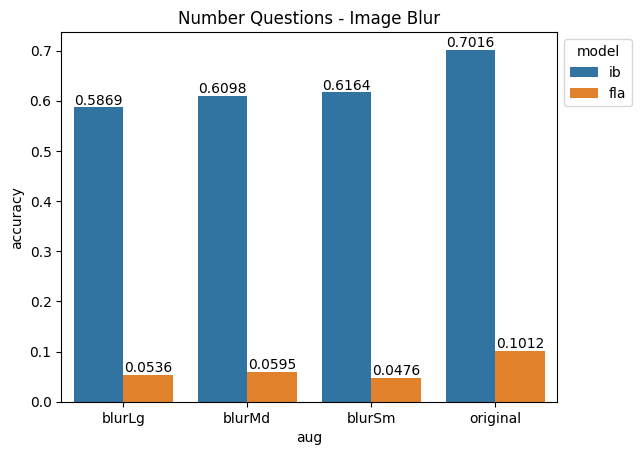

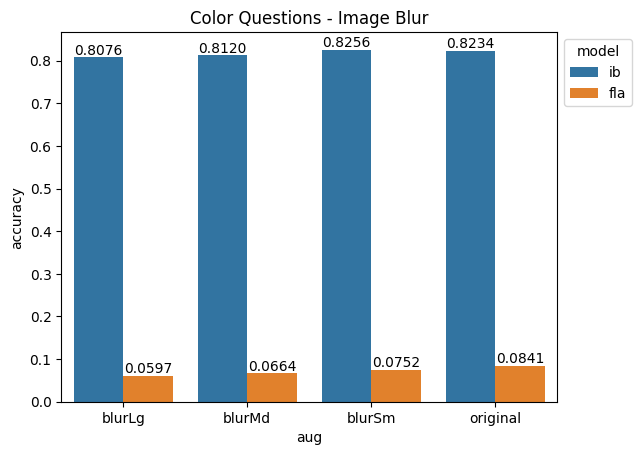

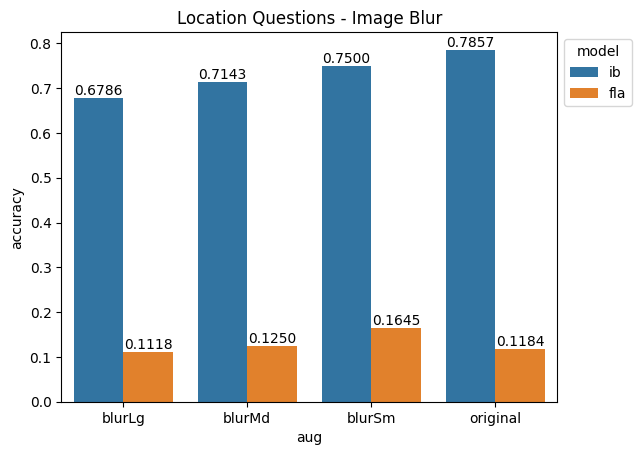

In [17]:

plot_blur_results(q_all, 'All Question Types - Image Blur')
plot_blur_results(q_0, 'Object Questions - Image Blur')
plot_blur_results(q_1, 'Number Questions - Image Blur')
plot_blur_results(q_2, 'Color Questions - Image Blur')
plot_blur_results(q_3, 'Location Questions - Image Blur')


### Elastic Transform Results

In [ ]:
plot_elastic_transform_results(q_all, 'All Question Types - Elastic Transform')
plot_elastic_transform_results(q_0, 'Object Questions - Elastic Transform')
plot_elastic_transform_results(q_1, 'Number Questions - Elastic Transform')
plot_elastic_transform_results(q_2, 'Color Questions - Elastic Transform')
plot_elastic_transform_results(q_3, 'Location Questions - Elastic Transform')

### Channel Dropout Results

In [ ]:
plot_channel_drop_results(q_exColor, 'All Question Types (excluding color questions) - Channel Dropout')
plot_channel_drop_results(q_0, 'Object Questions - Channel Dropout')
plot_channel_drop_results(q_1, 'Number Questions - Channel Dropout')
plot_channel_drop_results(q_3, 'Location Questions - Channel Dropout')

### Solarization Results

In [ ]:
plot_solarization_results(q_exColor, 'All Question Types (excluding color questions) - Solarization')
plot_solarization_results(q_0, 'Object Questions - Solarization')
plot_solarization_results(q_1, 'Number Questions - Solarization')
plot_solarization_results(q_3, 'Location Questions - Solarization')

### All Results

In [15]:
merge_results()

,index,accuracy,model,aug,metric,_
6,ib_blurLg_exact_accuracy,0.663051,ib,blurLg,exact,accuracy
4,ib_blurMd_exact_accuracy,0.670596,ib,blurMd,exact,accuracy
2,ib_blurSm_exact_accuracy,0.688944,ib,blurSm,exact,accuracy
8,ib_chnlDrp_exact_accuracy,0.645690,ib,chnlDrp,exact,accuracy
12,ib_elastic_exact_accuracy,0.699618,ib,elastic,exact,accuracy
0,ib_original_exact_accuracy,0.707249,ib,original,exact,accuracy
10,ib_solar_exact_accuracy,0.636901,ib,solar,exact,accuracy
7,ib_blurLg_synonym_accuracy,0.723839,ib,blurLg,synonym,accuracy
5,ib_blurMd_synonym_accuracy,0.730784,ib,blurMd,synonym,accuracy
3,ib_blurSm_synonym_accuracy,0.745788,ib,blurSm,synonym,accuracy


In [27]:
# Dont include color questions in the "All Question Types" plot for chnlDrp and solar augmentations
q_all_all = q_all = q_all.set_index(q_all['index']).copy()
q_exColor_all = q_exColor.set_index(q_exColor['index']).copy()
q_all_all.at['ib_chnlDrp_exact_accuracy', 'accuracy'] = q_exColor_all.at['ib_chnlDrp_exact_accuracy', 'accuracy']
q_all_all.at['fla_chnlDrp_exact_accuracy', 'accuracy'] = q_exColor_all.at['fla_chnlDrp_exact_accuracy', 'accuracy']
q_all_all.at['ib_solar_exact_accuracy', 'accuracy'] = q_exColor_all.at['ib_solar_exact_accuracy', 'accuracy']
q_all_all.at['fla_solar_exact_accuracy', 'accuracy'] = q_exColor_all.at['fla_solar_exact_accuracy', 'accuracy']

q_all_all = q_all_all.reset_index(drop=True)
q_exColor_all = q_exColor_all.reset_index(drop=True)

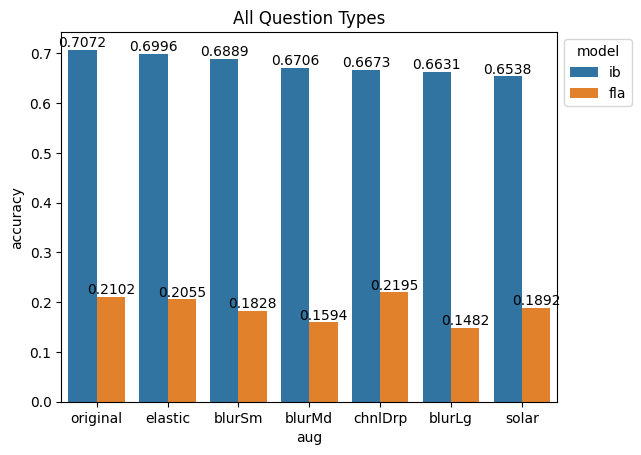

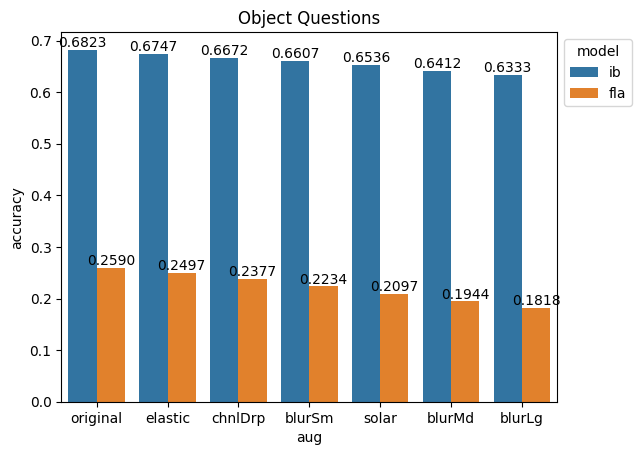

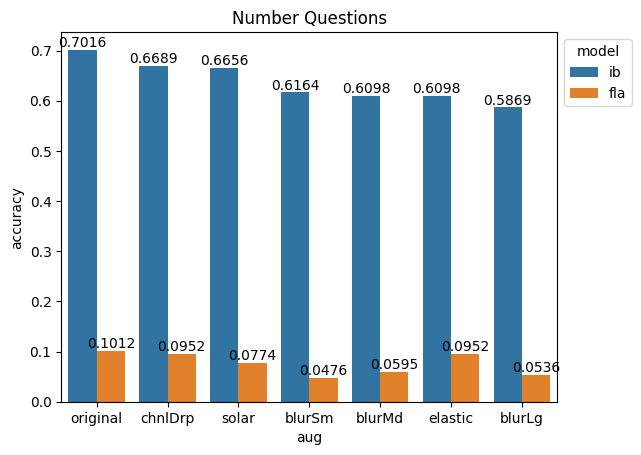

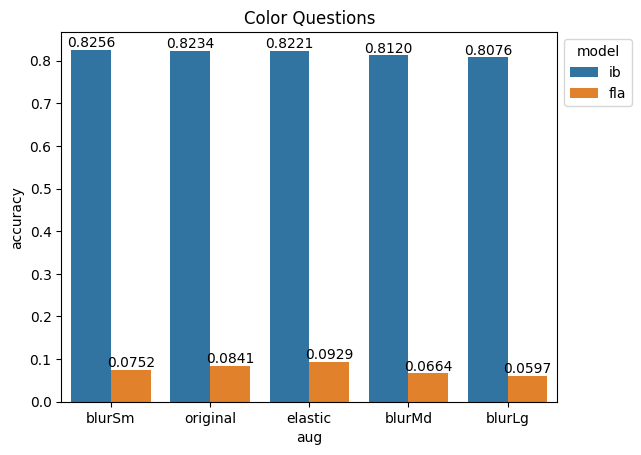

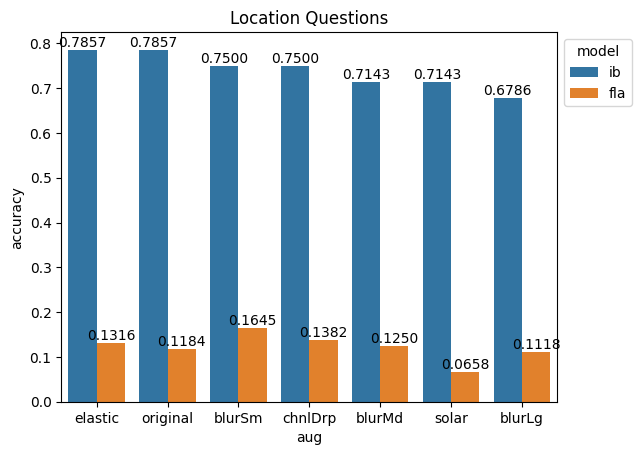

In [28]:
plot_all(q_all_all, 'All Question Types')
plot_all(q_0, 'Object Questions')
plot_all(q_1, 'Number Questions')
plot_all(q_2[~q_2['aug'].isin(['chnlDrp', 'solar'])], 'Color Questions')
plot_all(q_3, 'Location Questions')

### Incorrect Predictions

In [20]:
from pycocotools.coco import COCO

annFile = 'data/coco/annotations/instances_val2014.json'
coco=COCO(annFile)
# 0 -> object, 1 -> number, 2 -> color, 3 -> location


loading annotations into memory...
Done (t=2.51s)
creating index...
index created!


In [66]:
ib_preds = pd.concat([ib, ib_eval], axis=1)
# number questions 
num_qs = ib_preds[ib_preds['type'] == 1]
# get any samples that had incorrect predictions 
exact_accuracy_cols = [col for col in num_qs.columns if 'exact_accuracy' in col]
# num_qs = num_qs[num_qs[exact_accuracy_cols].eq(0).any(axis=1)]      # any prediction wrong

exact_accuracy_cols.remove('ib_original_exact_accuracy')
num_qs = num_qs[(num_qs[exact_accuracy_cols].eq(0).any(axis=1)) & (num_qs['ib_original_exact_accuracy'] == 1)]      # original prediction correct and aug prediction wrong

display(num_qs.head())
print(num_qs.shape[0], ' samples')

,img_id,question,answer,type,ib_original,ib_blurSm,ib_blurMd,ib_blurLg,ib_chnlDrp,ib_solar,...,ib_blurMd_exact_accuracy,ib_blurMd_synonym_accuracy,ib_blurLg_exact_accuracy,ib_blurLg_synonym_accuracy,ib_chnlDrp_exact_accuracy,ib_chnlDrp_synonym_accuracy,ib_solar_exact_accuracy,ib_solar_synonym_accuracy,ib_elastic_exact_accuracy,ib_elastic_synonym_accuracy
19120,111434,"how many plates with cakes sit on a table ,",four,1,4,4,5,5,4,4,...,0,0,0,0,1,1,1,1,0,0
19133,67959,how many donuts in a box with different toppin...,four,1,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,0,0
19208,69923,how many people on the beach standing with sur...,three,1,3,4,4,4,3,4,...,0,0,0,0,1,1,0,0,1,1
19283,54513,how many bananas are there that are on a small...,three,1,3,2,2,2,3,3,...,0,0,0,0,1,1,1,1,1,1
19324,440842,how many giraffe is standing next to each othe...,two,1,two,two,two,two,two,two,...,1,1,1,1,1,1,1,1,0,0


79  samples


In [ ]:
import skimage.io as io
import albumentations as A

import math
def plot_row_images(images, ids, titles=None):
    if not titles:
        titles = ['' for img in images]

    fig, ax = plt.subplots(1, len(images), figsize=(35,20))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax[i].imshow(img)
        if i == 0:
            ax[i].set_title(title[0])
        ax[i].set_xlabel(title[1])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.savefig(f'output/image_{ids[0]}')
    fig.show()

for i, row in num_qs.iterrows():
    img = coco.loadImgs([row['img_id']])[0]
    img = io.imread(img['coco_url'])
    prompt = row['question'] + '?'

    plt_imgs, plt_titles = [], []
    
    ## Original Image
    ib_generated_text = row['ib_original']
    # fla_generated_text = row['fla_original']
    fla_generated_text = 'xxxx'
    plt_imgs.append(img)
    plt_titles.append((f"ORIGINAL -- ID: {row['img_id']} \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_generated_text} -- OpenFlamingo: {fla_generated_text}"))

    ## Blurred small
    blur1 = A.ReplayCompose([A.Blur(blur_limit=[15]*2, always_apply=True)])
    img_blur1 = blur1(image=img)['image']
    ib_blur1 = row['ib_blurSm']
    # fla_blur1 = row['fla_blurSm']
    fla_blur1 = 'xxxx'
    plt_imgs.append(img_blur1)
    plt_titles.append((f"Small Blur \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_blur1} -- OpenFlamingo: {fla_blur1}"))
    
    ## Blurred medium
    blur2 = A.ReplayCompose([A.Blur(blur_limit=[20]*2, always_apply=True)])
    img_blur2 = blur2(image=img)['image']
    ib_blur2 = row['ib_blurMd']
    # fla_blur2 = row['fla_blurMd']
    fla_blur2 = 'xxxx'
    plt_imgs.append(img_blur2)
    plt_titles.append((f"Medium Blur \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_blur2} -- OpenFlamingo: {fla_blur2}"))

    ## Blurred strong
    blur3= A.ReplayCompose([A.Blur(blur_limit=[22]*2, always_apply=True)])
    img_blur3 = blur3(image=img)['image']
    ib_blur3 = row['ib_blurLg']
    # fla_blur3 = row['fla_blurLg']
    fla_blur3 = 'xxxx'
    plt_imgs.append(img_blur3)
    plt_titles.append((f"Strong Blur \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_blur3} -- OpenFlamingo: {fla_blur3}"))

    ## Channell dropout
    chnl_drop = A.ReplayCompose([A.ChannelDropout(always_apply=True)])
    img_chnl_drop = chnl_drop(image=img)['image']
    ib_chnl_drop = row['ib_chnlDrp']
    # fla_chnl_drop =row['fla_chnlDrp']
    fla_chnl_drop = 'xxxx'
    plt_imgs.append(img_chnl_drop)
    plt_titles.append((f"Channel Dropout {'WARNING COLOR QUESTION' if row['type'] == 2 else ''} \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_chnl_drop} -- OpenFlamingo: {fla_chnl_drop}"))

    ## Solarize
    img_solar = A.augmentations.functional.solarize (img, threshold=128)
    ib_solar = row['ib_solar']
    # fla_solar = row['fla_solar']
    fla_solar = 'xxxx'
    plt_imgs.append(img_solar)
    plt_titles.append((f"Solarize {'WARNING COLOR QUESTION' if row['type'] == 2 else ''} \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_solar} -- OpenFlamingo: {fla_solar}"))

    ## Elastic transform - distorion
    elastic = A.ReplayCompose([A.ElasticTransform(alpha=5, sigma=50, always_apply=True)])
    img_elastic = elastic(image=img)['image']
    ib_elastic = row['ib_elastic']
    # fla_elastic = row['fla_elastic']
    fla_elastic = 'xxxx'
    plt_imgs.append(img_elastic)
    plt_titles.append((f"Elastic transform \n Q: {prompt} -- A: {row['answer']}", f"InstructBlip: {ib_elastic} -- OpenFlamingo: {fla_elastic}"))

    ## plot
    plot_row_images(
        images=plt_imgs,
        titles=plt_titles,
        ids=[row['img_id']]*7
    )
